In [ ]:
def parse_seer_pop_line(line):
    year_str = line[0:4]
    state_fips_str = line[6:8]
    county_fips_str = line[8:11]
    race_str = line[13:14]
    origin_str = line[14:15]
    sex_str = line[15:16]
    age_str = line[16:18]
    pop_str = line[18:26]

    year = int(year_str)
    state_fips = int(state_fips_str)
    county_fips = int(county_fips_str)
    race = int(race_str)
    origin = int(origin_str)
    sex = int(sex_str)
    age = int(age_str)
    population = int(pop_str)

    fips_str = f"{state_fips:02d}{county_fips:03d}"

    return {
        "year": year,
        "state_fips": state_fips,
        "county_fips": county_fips,
        "fips": fips_str,
        "race_code": race,
        "origin_code": origin,
        "sex_code": sex,
        "age_code": age,
        "population": population
    }


In [ ]:
import pandas as pd
from pathlib import Path

BASE_DIR =Path.cwd().resolve()

pop_filepath = (BASE_DIR / ".." / "Data" / "Population_Data" / "us.1969_2023.20ages.adjusted" / "us.1969_2023.20ages.adjusted.txt").resolve()

pop_records = []

with open(pop_filepath, 'r', encoding='utf-8') as f:
    for line in f:
        year_str = line[0:4]
        year = int(year_str)

        if year == 1989:
            row = parse_seer_pop_line(line)
            pop_records.append(row)

df_pop_1989 = pd.DataFrame(pop_records)

pop_filepath = (BASE_DIR / ".." / "Data" / "Population_Data" / "us.1990_2023.20ages.adjusted.expanded" / "us.1969_2023.20ages.adjusted.txt").resolve()

pop_records = []

with open(pop_filepath, 'r', encoding='utf-8') as f:
    for line in f:
        year_str = line[0:4]
        year = int(year_str)

        if 1990<= year <=2019:
            row = parse_seer_pop_line(line)
            pop_records.append(row)

df_pop_1990_2019 = pd.DataFrame(pop_records)



In [3]:
df_pop_full = pd.concat([df_pop_1989, df_pop_1990_2019], ignore_index=True)

In [4]:
def bin_age_pop(age_code):
    if age_code < 6:
        return "0-24"
    elif 6 <= age_code < 14:
        return "25-64"
    else:
        return "65+"

df_pop_full["age_bin"] = df_pop_full["age_code"].apply(bin_age_pop)

def bin_pop_race(race_code, origin_code):
    """
    race_code -> 1 = White, 2 = Black, 3 = AI/AN, 4 = API (in 1990+),
                 'other' catch-all for 3,4
    origin_code -> 0=Non-Hispanic, 1=Hispanic, 9=Not applicable
    """
    if race_code == 1 and origin_code == 0:
        return "white/non-hispanic"
    elif race_code != 1 or origin_code == 1:
        return "non-white/hispanic"
    else:
        return None

df_pop_full["race_bin"] = df_pop_full.apply(
    lambda row: bin_pop_race(row["race_code"], row["origin_code"]), axis=1
)

def bin_pop_sex(sex_code):
    if sex_code == 1:
        return 'M'
    else:
        return 'F'

df_pop_full["sex_bin"] = df_pop_full['sex_code'].apply(bin_pop_sex)


In [ ]:
from collections import defaultdict
from pathlib import Path
import pandas as pd

BASE_DIR = Path.cwd().resolve()

raw_filepath = (BASE_DIR / ".." / "Data" / "Population_Data" / "us.1969_2023.20ages.adjusted" / "us.1969_2023.20ages.adjusted.txt").resolve()

totals = defaultdict(int)

with open(raw_filepath, 'r', encoding='latin1') as f:
    for line in f:
        year = int(line[0:4])
        state = int(line[6:8])
        county = int(line[8:11])
        fips = f"{state:02d}{county:03d}"
        pop = int(line[18:26])
        if 1989 <= year <= 2019:
            totals[(fips, year)] += pop

records = [
    {"fips": f, "year": y, "Attribute": "Total", "Population": p}
    for (f, y), p in totals.items()
]
df_totals = pd.DataFrame(records)



In [ ]:
from pathlib import Path
import pandas as pd

BASE_DIR = Path.cwd().resolve()

edu_filepath = (BASE_DIR / ".." / "Data" / "Additional Data" / "Education2023.csv").resolve()

df = pd.read_csv(
    edu_filepath,
    dtype={"FIPS Code": str}, 
    encoding="cp1252" 
)

print(df.head())



In [ ]:
df["FIPS Code"] = df["FIPS Code"].str.zfill(5)


In [9]:
df[["Measure", "Year"]] = df["Attribute"].str.rsplit(", ", n=1, expand=True)


In [10]:
count_measures = [
    "Less than a high school diploma",
    "High school diploma only",
    "Some college (1-3 years)",
    "Four years of college or higher",
    "Less than high school graduate",
    "High school graduate (or equivalency)",
    "Some college or associate degree",
    "Bachelor's degree or higher",
]
df_cnt = df[df["Measure"].isin(count_measures)].copy()


In [11]:
map_cat = {
    # HS or less
    "Less than a high school diploma":           "HS_or_less",
    "High school diploma only":                   "HS_or_less",
    "Less than high school graduate":             "HS_or_less",
    "High school graduate (or equivalency)":      "HS_or_less",
    # Some college or more
    "Some college (1-3 years)":                   "SomeColl_or_more",
    "Some college or associate degree":           "SomeColl_or_more",
    "Four years of college or higher":            "SomeColl_or_more",
    "Bachelor's degree or higher":                "SomeColl_or_more",
}
df_cnt["Category"] = df_cnt["Measure"].map(map_cat)

In [12]:
df_wide = (
    df_cnt
      .pivot_table(
         index=["FIPS Code","Year"],
         columns="Category",
         values="Value",
         aggfunc="sum"    # sum the two relevant measures into each category
      )
      .reset_index()
)

In [13]:
year_map = {
    "1970":    1970,
    "1980":    1980,
    "1990":    1990,
    "2000":    2000,
    "2008-12": 2010,   # midpoint
    "2019-23": 2021,   # midpoint (we’ll filter later)
}
df_wide["Year_num"] = df_wide["Year"].map(year_map)

In [14]:
years = list(range(1970,2022))

In [ ]:
def interp_counts(group):
    #reindex to full year range and interpolate counts linearly
    g = group.set_index("Year_num").reindex(years)
    g[["HS_or_less","SomeColl_or_more"]] = (
        g[["HS_or_less","SomeColl_or_more"]]
          .interpolate(method="linear")
    )
    #carry FIPS Code forward/backward to fill the new rows
    g["FIPS Code"] = group["FIPS Code"].iloc[0]
    return g

df_interp = (
    df_wide
      .groupby("FIPS Code", as_index=False)
      .apply(interp_counts)
      .reset_index()
)
df_final = df_interp.reset_index(drop=True)


C:\Users\yegor\AppData\Local\Temp\ipykernel_10416\781388074.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(interp_counts)


In [16]:
df_edu = df_final[
    (df_final["Year_num"] >= 1989) &
    (df_final["Year_num"] <= 2019)
].reset_index(drop=True)

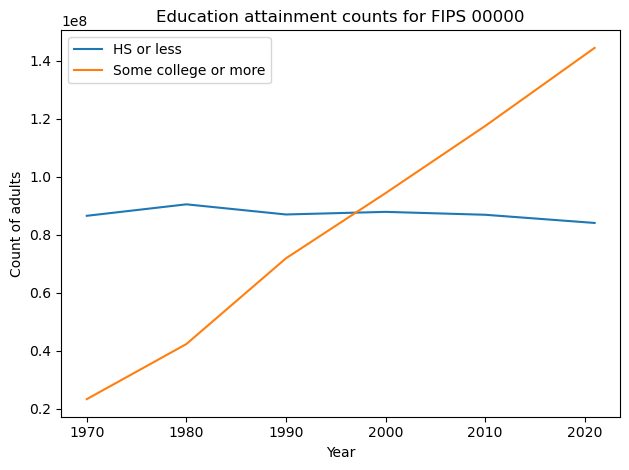

In [ ]:
#shit test
import matplotlib.pyplot as plt

fips_code = "00000"  # for example

df_f = df_final[df_final["FIPS Code"] == fips_code]

plt.figure()
plt.plot(df_f["Year_num"], df_f["HS_or_less"], label="HS or less")
plt.plot(df_f["Year_num"], df_f["SomeColl_or_more"], label="Some college or more")
plt.xlabel("Year")
plt.ylabel("Count of adults")
plt.title(f"Education attainment counts for FIPS {fips_code}")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

#population by age bin
df_age = (
    df_pop_full
    .groupby(["fips", "year", "age_bin"], as_index=False)["population"]
    .sum()
    .rename(columns={"age_bin": "Attribute", "population": "Population"})
)

#population by sex bin
df_sex = (
    df_pop_full
    .groupby(["fips", "year", "sex_bin"], as_index=False)["population"]
    .sum()
    .rename(columns={"sex_bin": "Attribute", "population": "Population"})
)

# population by race bin
df_race = (
    df_pop_full
    .groupby(["fips", "year", "race_bin"], as_index=False)["population"]
    .sum()
    .rename(columns={"race_bin": "Attribute", "population": "Population"})
)

#population by education
df2 = df_edu.drop(columns=["Category","level_0","Year"], errors="ignore")
df2 = df2.rename(columns={
    "FIPS Code": "fips",
    "Year_num":  "year"
})
df_edu_long = df2.melt(
    id_vars   = ["fips","year"],
    value_vars= ["HS_or_less","SomeColl_or_more"],
    var_name  = "Attribute",
    value_name= "Population"
)


#Stack them all together
df_attributes = pd.concat([ df_totals, df_age, df_sex, df_race, df_edu_long], ignore_index=True)

#keep only the four columns and reorder
df_attributes = df_attributes[["fips", "year", "Attribute", "Population"]]

df_attributes = df_attributes.dropna(subset=["Population"])
df_attributes["Population"] = df_attributes["Population"].astype(int)
print(df_attributes)


In [ ]:
from pathlib import Path

BASE_DIR = Path.cwd().resolve()
output_path = (BASE_DIR / ".." / "Analysis" / "Analysis_Data" / "population_counts.csv").resolve()

df_attributes.to_csv(output_path, index=False)
